# 1: Spatial and Measurement Functions

Demonstrate the usage of spatial measurement functions.

@author: Guihong Wan and Boshen Yan      
@date: Aug 20, 2023     
@last updated: Oct 6, 2023

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import spatialcells as spc

In this tutorial, we will be demonstrating the spatial measurements functions by studying the distribution of MITF+ cells among SOX10+ tumor cells

## Read and process data


You can download the data from [here](https://www.dropbox.com/scl/fo/coek1wvi9n0syv5tokus1/h?rlkey=1yvizq0joir6q73iosov608ou&dl=0). Please refer to the original [paper](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and) for the details.

In [2]:
adata = ad.read_h5ad("../../data/MEL1_adata.h5ad")

In [3]:
spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug=True)
spc.prep.setGate(adata, "MITF_cellRingMask", 6.3, debug=True)
spc.prep.setGate(adata, "KERATIN_cellRingMask", 6.4, debug=True)

SOX10_cellRingMask_positive
False    566576
True     544009
Name: count, dtype: int64
MITF_cellRingMask_positive
False    851822
True     258763
Name: count, dtype: int64
KERATIN_cellRingMask_positive
False    1067400
True       43185
Name: count, dtype: int64


In [4]:
def combine_columns(row):
    if row["MITF_cellRingMask_positive"] and row["SOX10_cellRingMask_positive"]:
        return "SOX10+MITF+"
    elif row["SOX10_cellRingMask_positive"]:
        return "SOX10+MITF-"
    else:
        return "SOX10-"


# Applying the function to create the new phenotype column
adata.obs["pheno"] = adata.obs.apply(combine_columns, axis=1)

The following steps compute the communities based on SOX10+ cells.

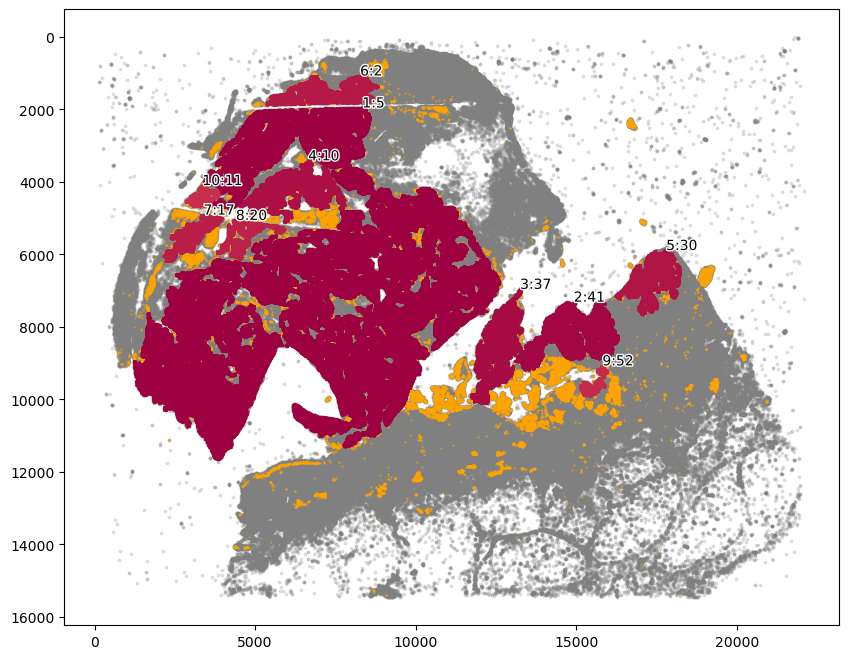

In [5]:
markers_of_interest = ["SOX10_cellRingMask_positive"]

communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(
    adata, markers_of_interest, eps=50, newcolumn=communitycolumn
)
# Plotting the communities
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

In [6]:
# Here we chose the main tumor area.
communityIndexList = [5, 2, 10, 11, 17, 20]

## getBoundary    

In [7]:
boundary = spc.spa.getBoundary(adata, communitycolumn, communityIndexList, alpha=150)
pruned_boundary = spc.spa.pruneSmallComponents(
    boundary, min_edges=20, holes_min_edges=200
)

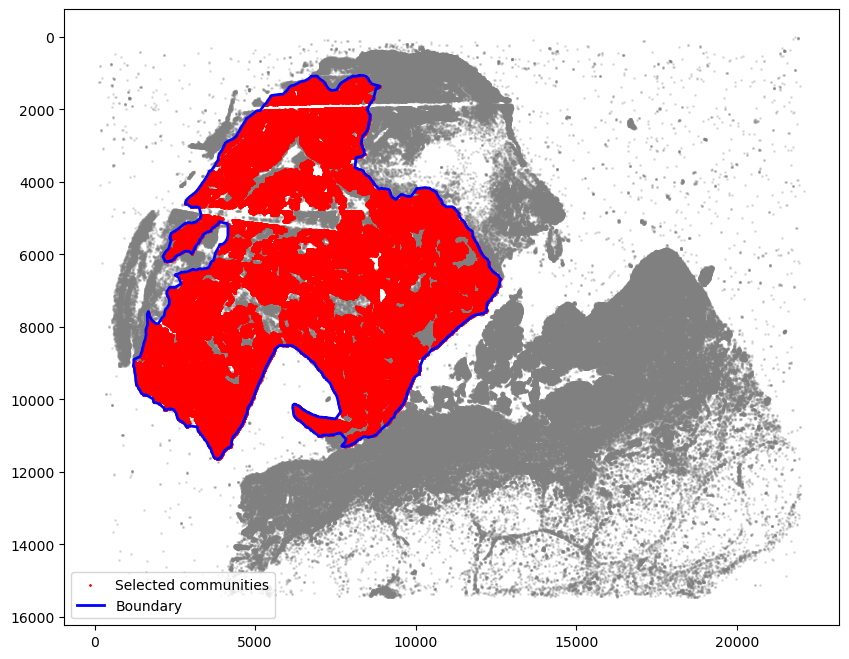

In [8]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r", label="Selected communities")

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary, ax=ax, linewidth=2, color="b", label="Boundary")
ax.invert_yaxis()
ax.legend(loc="lower left")
plt.show()

## assignPointsToRegion

In [9]:
regions = ["Tumor"]
boundaries_list = [pruned_boundary]
spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="BG"
)

719117it [00:58, 12263.00it/s]


Assigned points to region: Tumor


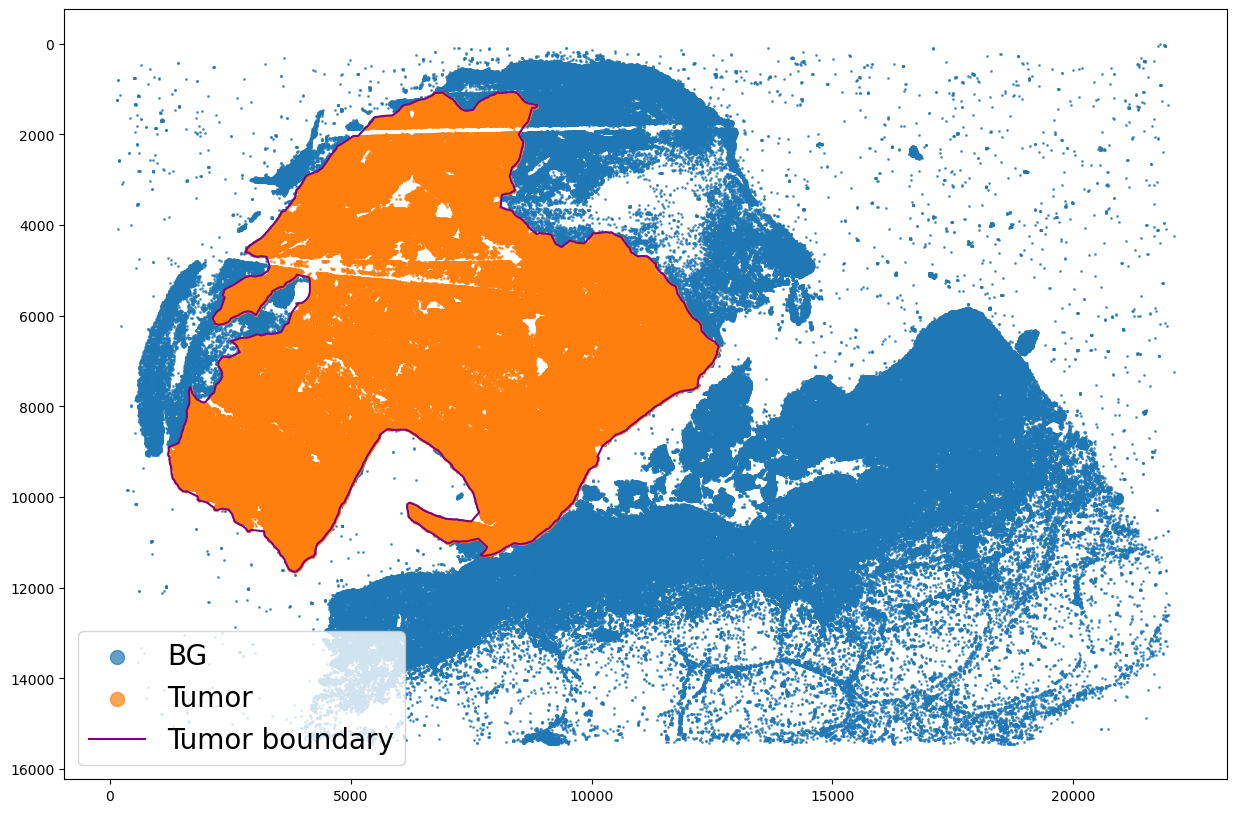

In [10]:
point_size = 1
fig, ax = plt.subplots(figsize=(15, 10))

for region in sorted(set(adata.obs["region"])):
    tmp = adata[adata.obs.region == region]
    ax.scatter(
        *zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()),
        s=point_size,
        alpha=0.7,
        label=region
    )

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary, color="purple", label="Tumor boundary")

ax.invert_yaxis()
plt.legend(loc="lower left", markerscale=10, fontsize=20)
plt.show()

First we calculate the overall Tumor region composition.

In [11]:
roi_comp = spc.msmt.getRegionComposition(adata, "pheno", regions=["Tumor"])
roi_comp

pheno  cell_count  composition
0  SOX10+MITF-      252594     0.437427
1  SOX10+MITF+      195279     0.338172
2       SOX10-      129581     0.224401

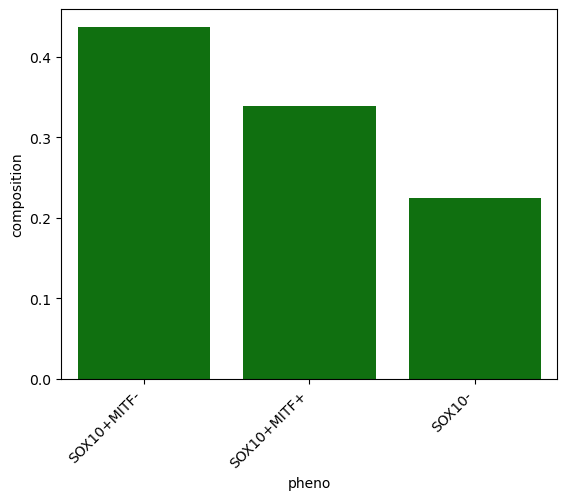

In [12]:
sns.barplot(x="pheno", y="composition", color="green", data=roi_comp)
plt.xticks(rotation=45, ha="right")
plt.show()

#### Tumor area and density

In [13]:
area = spc.msmt.getRegionArea(pruned_boundary)
print("area: ", area)

density = spc.msmt.getRegionDensity(
    adata, 
    pruned_boundary, 
    region_subset=["Tumor"])
print("All cell density/100px2: ", density.values[0] * 10000, "\n")

sox10_density = spc.msmt.getRegionDensity(
    adata,
    pruned_boundary,
    region_subset=["Tumor"],
    phenotype_col=["SOX10_cellRingMask_positive"],
)
print("SOX10 positive cell density in tumor/100px2:\n", sox10_density * 10000, "\n")


pheno_density = spc.msmt.getRegionDensity(
    adata, 
    pruned_boundary, 
    region_subset=["Tumor"], 
    phenotype_col=["pheno"]
)
print("pheno density in tumor/100px2:\n", pheno_density * 10000)

area:  66103699.31245056
All cell density/100px2:  87.35577675775208 

SOX10 positive cell density in tumor/100px2:
 SOX10_cellRingMask_positive
True                           67.753092
False                          19.602685
Name: count, dtype: float64 

pheno density in tumor/100px2:
 pheno      
SOX10+MITF-    38.211780
SOX10+MITF+    29.541312
SOX10-         19.602685
Name: count, dtype: float64


## Tumor organization

In [14]:
centroid = spc.msmt.getRegionCentroid(pruned_boundary)
edge_pt = [2000, 2000]

In [15]:
help(spc.msmt.getDistanceFromPoint)

Help on function getDistanceFromPoint in module spatialcells.measurements._getDistanceFromPoint:

getDistanceFromPoint(adata, point, x='X_centroid', y='Y_centroid', region_col='region', region_subset=None, metric='angular', name='distance', inplace=True, binned=False, binsize=10)
    Get the distance of each cell from a point.
    
    :param adata: Anndata object
    :param point: iterable coordinate of a point in (x, y) to calculate distance from
    :param x: Name of the column containing the x coordinate. Default is "X_centroid".
    :param y: Name of the column containing the y coordinate. Default is "Y_centroid".
    :param region_col: Name of the column containing the region. Default is "region".
    :param region_subset: List of regions to consider. If None, consider all cells.
    :param metric: metric to use for distance calculation. 
        Metric can be "angular" or "euclidean". Default is "angular".
    :param name: Name of the column to store the distance in. Default is 

In [16]:
spc.msmt.getDistanceFromPoint(
    adata,
    centroid,
    region_subset=["Tumor"],
    metric="euclidean",
    name="euc_distance",
    binned=True,
    binsize=1000,
)

spc.msmt.getDistanceFromPoint(
    adata,
    centroid,
    region_subset=["Tumor"],
    metric="angular",
    name="ang_distance",
    binned=True,
    binsize=45,
)

spc.msmt.getDistanceFromPoint(
    adata,
    edge_pt,
    region_subset=["Tumor"],
    metric="euclidean",
    name="euc_edge",
    binned=True,
    binsize=1500,
)

spc.msmt.getDistanceFromPoint(
    adata,
    edge_pt,
    region_subset=["Tumor"],
    metric="angular",
    name="ang_edge",
    binned=True,
    binsize=30,
)

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


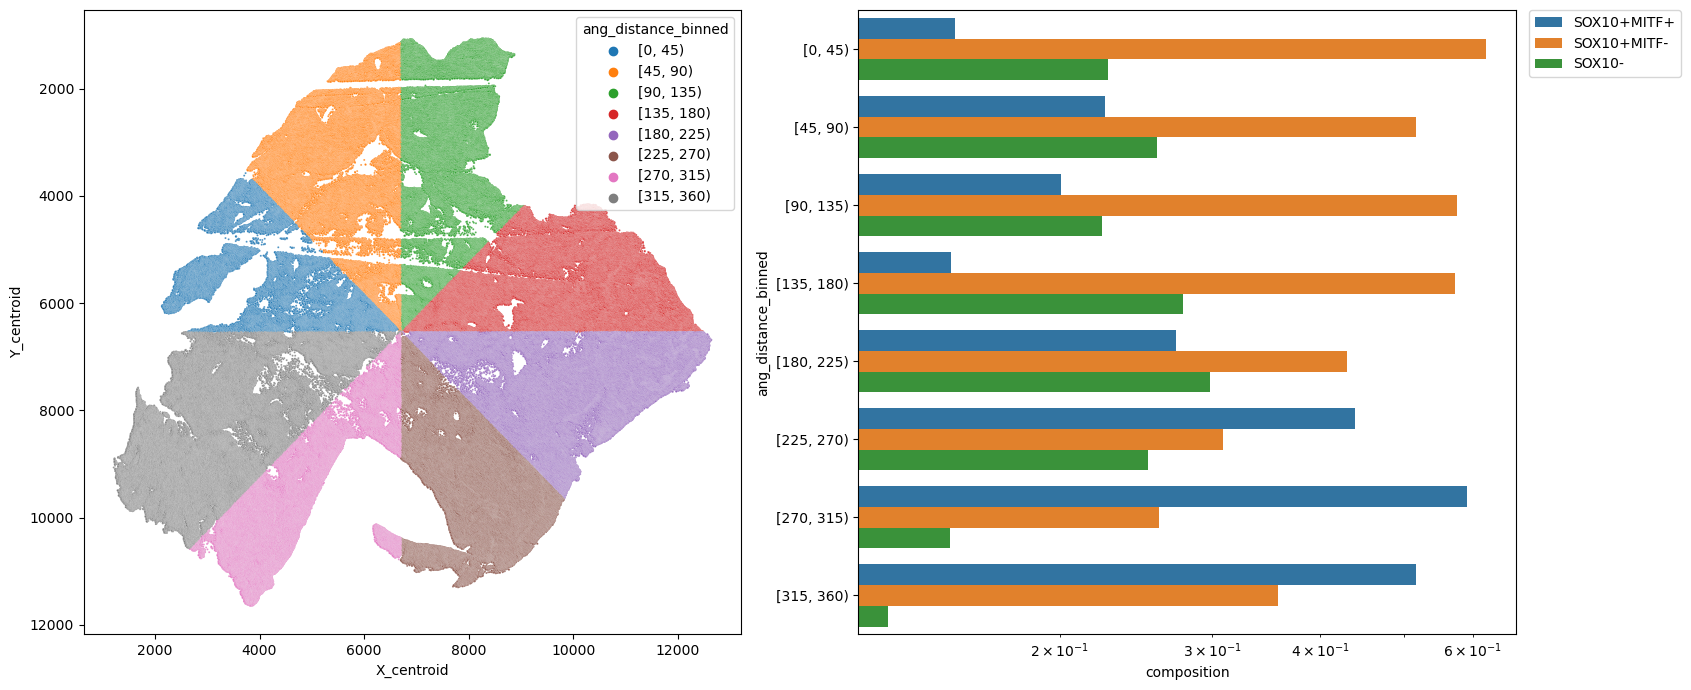

In [17]:
metric_col = "ang_distance_binned"
pheno = "pheno"

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))
sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)

df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


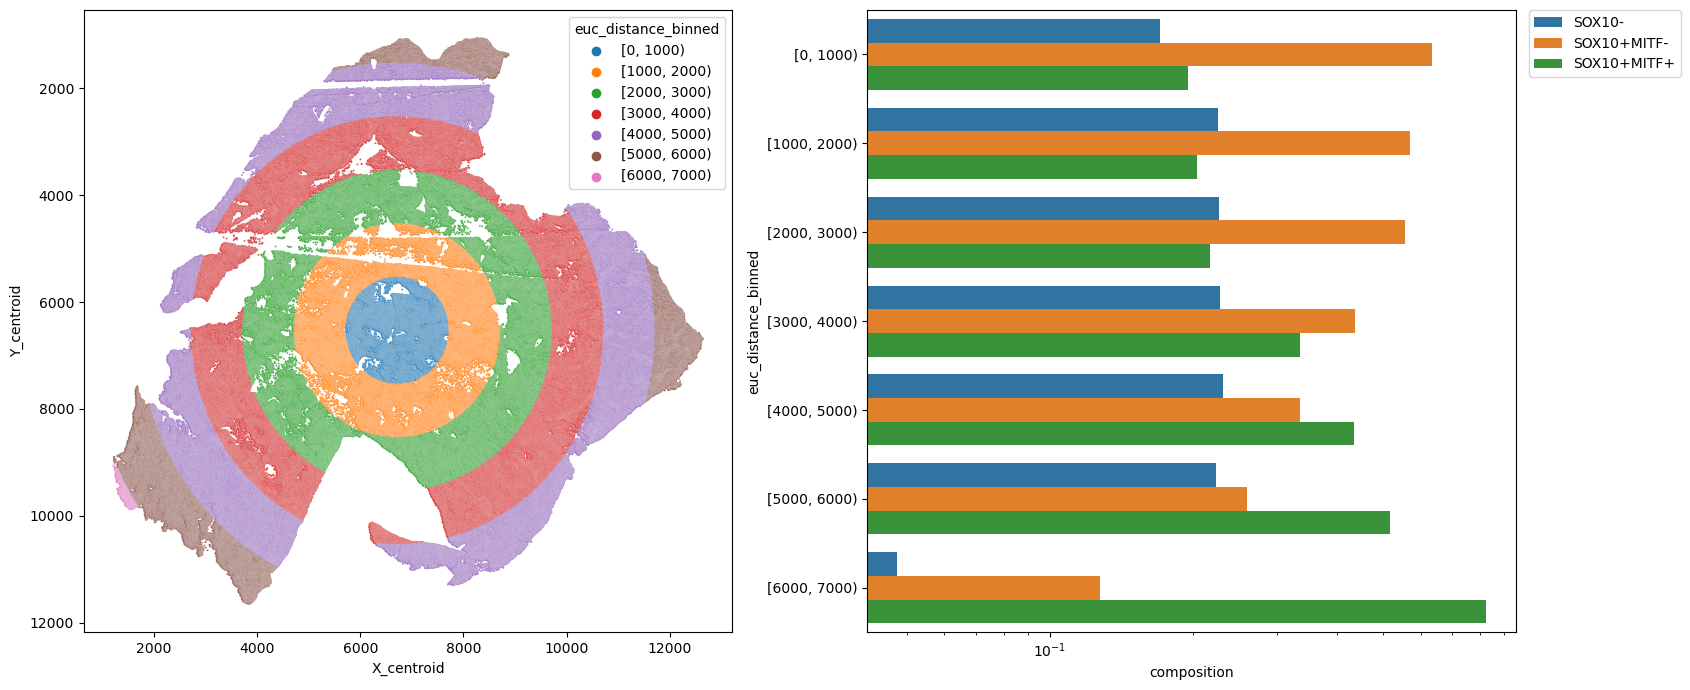

In [18]:
metric_col = "euc_distance_binned"
pheno = "pheno"
df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))
sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


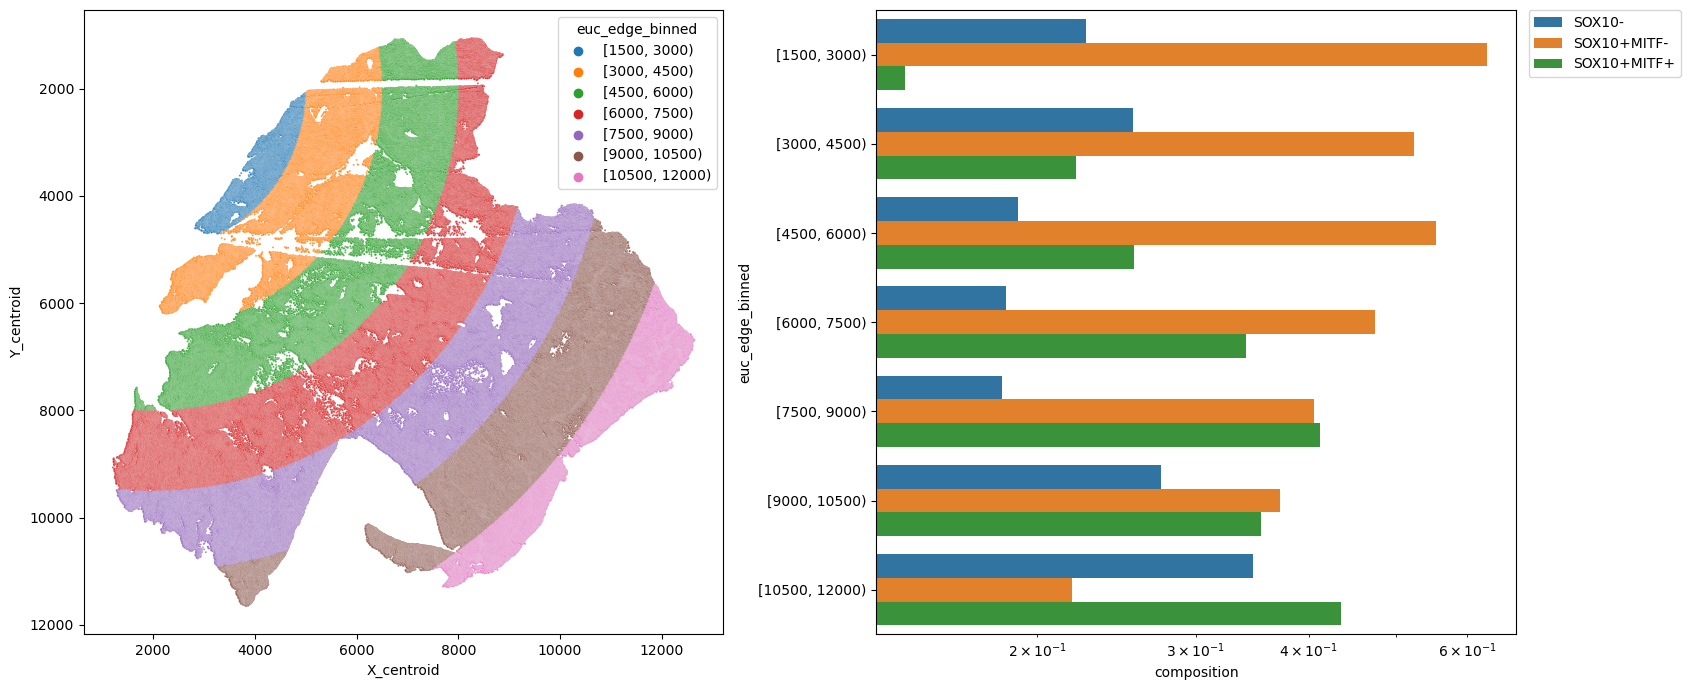

In [19]:
metric_col = "euc_edge_binned"
pheno = "pheno"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))
sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)
df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


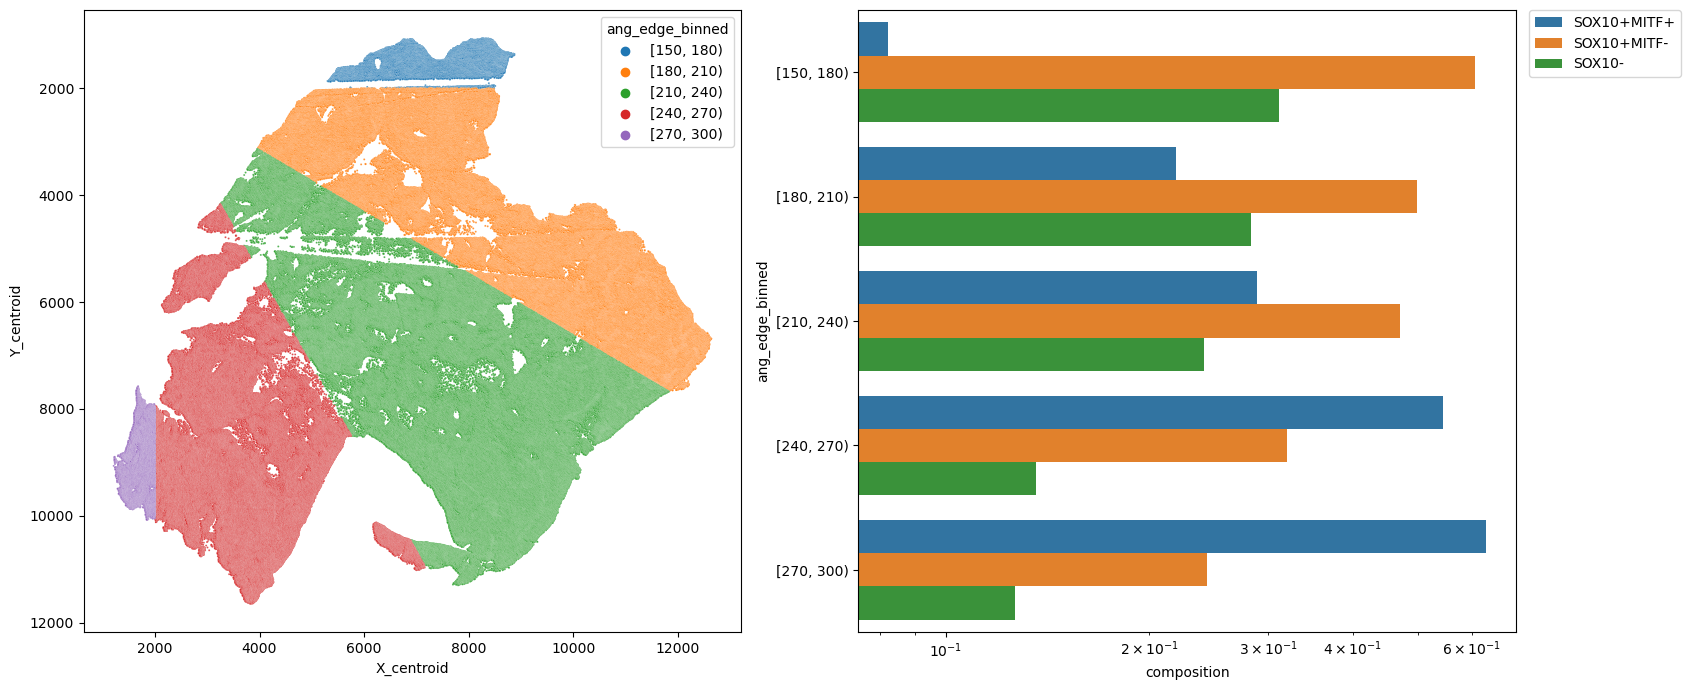

In [20]:
metric_col = "ang_edge_binned"
pheno = "pheno"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))
sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)
df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

#### Get distance from the epidermis layer

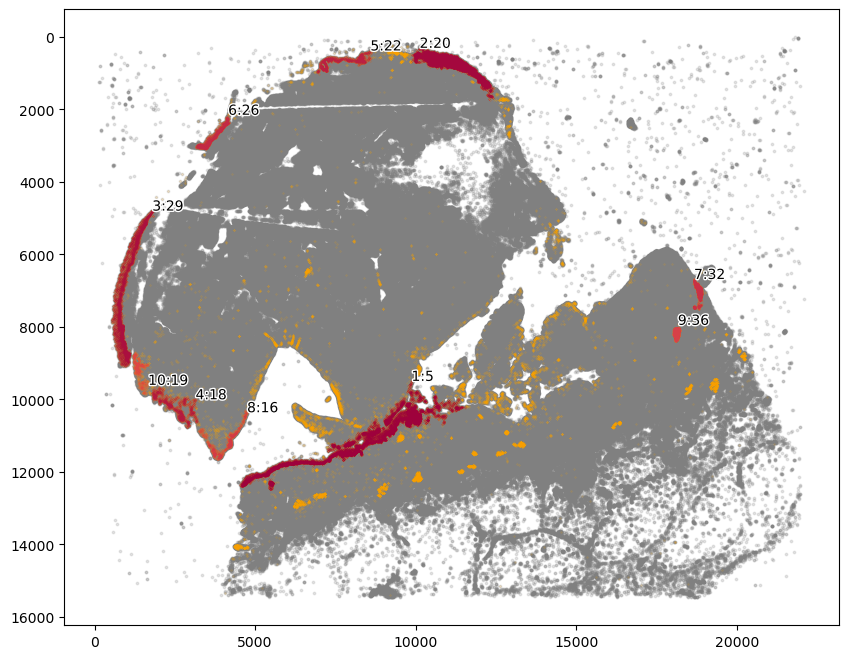

In [21]:
# find skin cell communities
marker = ["KERATIN_cellRingMask_positive"]
communitycolumn = "epi_community"
ret = spc.spatial.getCommunities(adata, marker, eps=100, newcolumn=communitycolumn)
# Plotting the communities
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=0.1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

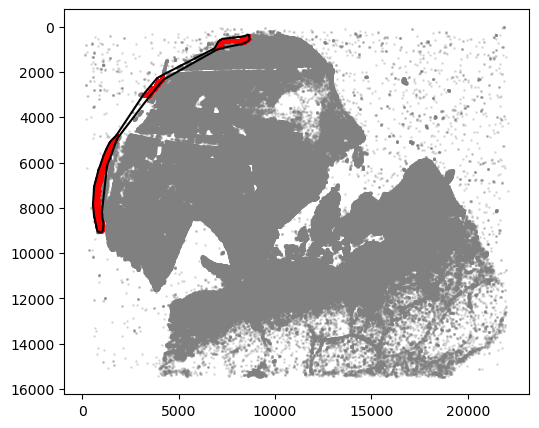

In [22]:
communityIndexList = [22, 26, 29]
epi_boundary = spc.spa.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=3000
)
markersize = 1
fig, ax = plt.subplots(figsize=(6, 5))
## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
spc.plt.plotBoundary(epi_boundary, ax=ax, linewidth=1.5, color="k")
ax.invert_yaxis()
plt.show()

For demonstration, we included a custom, manually drawn line as well. In general, any Shapely object should work

In [23]:
from shapely.geometry import LineString

# manually input the line
shapely_obj = LineString([(12000, 2000), (13000, 3000), (13500, 3800)])

In [24]:
help(spc.msmt.getDistanceFromObject)

Help on function getDistanceFromObject in module spatialcells.measurements._getDistanceFromObject:

getDistanceFromObject(adata, object, x='X_centroid', y='Y_centroid', region_col='region', region_subset=None, name='distance', inplace=True, binned=False, binsize=10)
    Get the minimum euclidean distance between each cell and a shapely object.
    
    :param adata: Anndata object
    :param object: Shapely object to measure distance from
    :param x: Name of the column containing the x coordinate. Default is "X_centroid".
    :param y: Name of the column containing the y coordinate. Default is "Y_centroid".
    :param region_col: Name of the column containing the region. Default is "region".
    :param region_subset: List of regions to consider. If None, consider all cells.
    :param name: Name of the column to store the distance in. Default is "distance".
    :param inplace: If True, add the distance column to adata.obs. If False, return a copy
    :param binned: If True, bin the d

In [25]:
spc.msmt.getDistanceFromObject(
    adata,
    epi_boundary,
    region_col="region",
    region_subset=["Tumor"],
    name="distance_from_epidermis",
    binned=True,
    binsize=1000,
)
spc.msmt.getDistanceFromObject(
    adata,
    shapely_obj,
    region_col="region",
    region_subset=["Tumor"],
    name="distance_from_object",
    binned=True,
    binsize=1000,
)

577454it [00:15, 36305.82it/s]
577454it [00:12, 47052.12it/s]


In [26]:
metric_col = "distance_from_epidermis_binned"
pheno = "pheno"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax1.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r")
spc.plt.plotBoundary(epi_boundary, ax=ax1, linewidth=1.0, color="k")

sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="upper right", title=metric_col)
df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


In [27]:
metric_col = "distance_from_object_binned"
pheno = "pheno"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(17, 7))
# plot manually drawn shape
ax1.plot(*shapely_obj.xy, color="k", linewidth=5)

sns.scatterplot(
    data=adata.obs,
    x="X_centroid",
    y="Y_centroid",
    hue=metric_col,
    alpha=0.8,
    s=2,
    ax=ax1,
)
ax1.invert_yaxis()
ax1.legend(loc="lower right", title=metric_col)
df = spc.msmt.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ghwan/opt/anaconda3/envs/spatialcells/lib/python3.10/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


#### Sliding window analysis

We can also divide the tumor region into square windows and get the cell composition within each window. This can be matched with patch-level image analysis to provide additional features

In [28]:
help(spc.msmt.getSlidingWindowsComposition)

Help on function getSlidingWindowsComposition in module spatialcells.measurements._getSlidingWindowsComposition:

getSlidingWindowsComposition(adata, window_size, step_size, phenotype_col, region_col='region', region_subset=None, min_cells=0)
    Get Sliding window cell composition for cells in region subset.
    
    :param adata: Anndata object
    :param window_size: Size of the sliding window
    :param step_size: Size of the step
    :param phenotype_col: list of columns containing the cell type markers,
        for cell type composition
    :param region_col: Column containing the region information
    :param region_subset: List of regions to consider. If None, consider all cells.
    :param min_cells: Minimum number of cells in a window to consider it
    :returns: A dataframe containing the cell type composition of the region in each window



In [29]:
size = 300
adata1 = adata[adata.obs["SOX10_cellRingMask_positive"]]
mitf_df = spc.msmt.getSlidingWindowsComposition(
    adata = adata1, 
    window_size = size, 
    step_size = size, 
    phenotype_col = "pheno", 
    region_subset=["Tumor"], 
    min_cells = 10
)

In [30]:
mitf_df

pheno  cell_count  composition  X_start  Y_start  window_size  \
0   SOX10+MITF-          77     0.865169     1211     8562          300   
1   SOX10+MITF+          12     0.134831     1211     8562          300   
0   SOX10+MITF-         215     0.520581     1211     8862          300   
1   SOX10+MITF+         198     0.479419     1211     8862          300   
0   SOX10+MITF+         643     0.883242     1211     9162          300   
..          ...         ...          ...      ...      ...          ...   
1   SOX10+MITF+         169     0.288889    12311     6462          300   
0   SOX10+MITF-         273     0.505556    12311     6762          300   
1   SOX10+MITF+         267     0.494444    12311     6762          300   
0   SOX10+MITF+          97     0.683099    12311     7062          300   
1   SOX10+MITF-          45     0.316901    12311     7062          300   

    step_size  
0         300  
1         300  
0         300  
1         300  
0         300  
..        ...  
1         300  
0         300  
1         300  
0         300  
1         300  

[1605 rows x 7 columns]

To plot non-overlapping windows, we can first create a numpy mask representing the composition for cell types of interest in each window.

In [31]:
help(spc.msmt.get_comp_mask)

Help on function get_comp_mask in module spatialcells.measurements._getSlidingWindowsComposition:

get_comp_mask(df, pheno_col, pheno_vals, step_size)
    Get a mask of the composition of the region in each window
    
    :param df: A dataframe containing the cell type composition of pheno_vals in each window
    :param pheno_col: Column containing the cell type information
    :param pheno_vals: List of cell types to consider
    :param step_size: Size of the step
    :return: A np array mask of the composition of the region in each window



In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

mask = spc.msmt.get_comp_mask(mitf_df, "pheno", ["SOX10+MITF+"], size)
plt.imshow(mask, alpha=0.9, cmap="Reds", extent=(0, 1, 0, 1))

cbar = plt.colorbar()
cbar.ax.set_ylabel("SOX10+MITF+ cells percentage")
for region in sorted(set(adata.obs["region"])):
    tmp = adata.obs[adata.obs.region == region].sample(frac=0.1)
    ax.scatter(
        *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
        s=1,
        alpha=0.01,
        color="grey"
    )
# Bounds of points in selected communities
spc.plt.plotBoundary(pruned_boundary, color="purple", label="Tumor boundary")
ax.imshow(mask, alpha=1, cmap="Reds")
plt.legend(loc="upper right", markerscale=10)
plt.show()